In [1]:
TYPE_PC = False # True For Mac   -   False Ubuntu

In [2]:
### Import libraries

import sys

if TYPE_PC:
    sys.path.append('/home/daniel/Documents/phd/phd-thesis-lab/12-third_year/05-CommunityDetection/')
else:
    sys.path.append('/home/daniel/Documents/phd/phd-thesis-lab/12-third_year/05-CommunityDetection/')

import pandas as pd
import igraph as ig
import numpy as np
import matplotlib.pyplot as plt
import auxiliar_path

In [3]:
### Global variables
### Global variables

DATASET = "AMZ" # AMZ, HC, PM, UN, TOY
NODE_TYPE = False

PATH_DATASET = auxiliar_path.get_path_dataset(DATASET)
PATH_NODETYPE = auxiliar_path.get_path_topbot(NODE_TYPE)

if TYPE_PC:
    GLOBAL_PATH = "/Users/ddiaz/Documents/code/phd-thesis-lab/12-third_year/"    
else:
    GLOBAL_PATH = "/home/daniel/Documents/phd/phd-thesis-lab/12-third_year/"

# File CSVpa
### GLOBAL variables
GRAPH_PATH = GLOBAL_PATH + "00-Data/" + PATH_DATASET + "/02-Graphs/"+PATH_NODETYPE+"/AMZ_bot_weights_NC_alph2.graphml"
print(GRAPH_PATH)

/home/daniel/Documents/phd/phd-thesis-lab/12-third_year/00-Data/01-AMZ/02-Graphs/02-Bot/AMZ_bot_weights_NC_alph2.graphml


In [35]:
import igraph as ig
import random
from itertools import combinations
from collections import defaultdict

def jaccard_index(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0.0

def run_louvain_iterations(g, iterations=10):
    same_community_neighbors = defaultdict(list)

    for _ in range(iterations):
        partition = g.community_multilevel()
        membership = partition.membership

        # Creamos un mapa rápido de nodo -> comunidad
        node_to_comm = {v.index: membership[v.index] for v in g.vs}

        for v in g.vs:
            v_id = v["id"]
            community_neighbors = set()

            for neighbor in g.neighbors(v):
                if node_to_comm[neighbor] == node_to_comm[v.index]:
                    community_neighbors.add(g.vs[neighbor]["id"])

            same_community_neighbors[v_id].append(community_neighbors)

    return same_community_neighbors

def compute_jaccard_stability(same_community_neighbors):
    stability_scores = {}

    for node_id, neighbor_sets in same_community_neighbors.items():
        if len(neighbor_sets) < 2:
            stability_scores[node_id] = 1.0
            continue

        jaccard_scores = []
        for s1, s2 in combinations(neighbor_sets, 2):
            jaccard_scores.append(jaccard_index(s1, s2))

        stability_scores[node_id] = sum(jaccard_scores) / len(jaccard_scores)

    return stability_scores


# Ejecutar el experimento
neighbors_by_iteration = run_louvain_iterations(g, iterations=10)
jaccard_stability = compute_jaccard_stability(neighbors_by_iteration)

# Mostrar algunos resultados
for node, stability in sorted(jaccard_stability.items(), key=lambda x: x[1]):
    print(f"Nodo {node}: Jaccard promedio = {stability:.3f}")


Nodo 9812.0: Jaccard promedio = 0.000
Nodo 9822.0: Jaccard promedio = 0.000
Nodo 9878.0: Jaccard promedio = 0.000
Nodo 10005.0: Jaccard promedio = 0.000
Nodo 10052.0: Jaccard promedio = 0.000
Nodo 10086.0: Jaccard promedio = 0.000
Nodo 10159.0: Jaccard promedio = 0.000
Nodo 10227.0: Jaccard promedio = 0.000
Nodo 10256.0: Jaccard promedio = 0.000
Nodo 10263.0: Jaccard promedio = 0.000
Nodo 10296.0: Jaccard promedio = 0.000
Nodo 10306.0: Jaccard promedio = 0.000
Nodo 10318.0: Jaccard promedio = 0.000
Nodo 10322.0: Jaccard promedio = 0.000
Nodo 10400.0: Jaccard promedio = 0.000
Nodo 10403.0: Jaccard promedio = 0.000
Nodo 10444.0: Jaccard promedio = 0.000
Nodo 10452.0: Jaccard promedio = 0.000
Nodo 10454.0: Jaccard promedio = 0.000
Nodo 10455.0: Jaccard promedio = 0.000
Nodo 10457.0: Jaccard promedio = 0.000
Nodo 10538.0: Jaccard promedio = 0.000
Nodo 10560.0: Jaccard promedio = 0.000
Nodo 10564.0: Jaccard promedio = 0.000
Nodo 10596.0: Jaccard promedio = 0.000
Nodo 10617.0: Jaccard promed

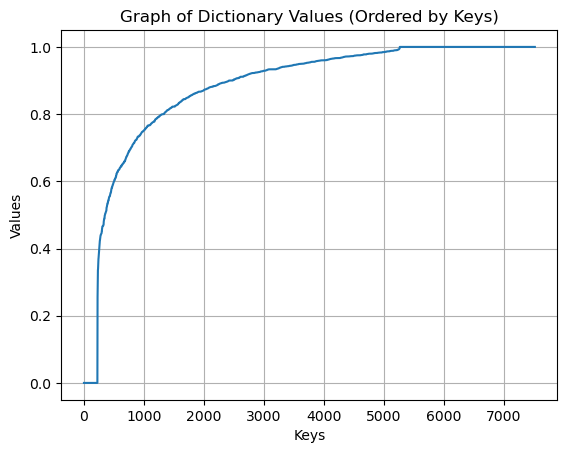

In [36]:

# Create the plot
plt.plot(range(len(jaccard_stability.values())), sorted(list(jaccard_stability.values())))
plt.xlabel("Keys")
plt.ylabel("Values")
plt.title("Graph of Dictionary Values (Ordered by Keys)")
plt.grid(True)
plt.show()

In [5]:
### Read GRAPH

g = ig.read(GRAPH_PATH)
print(g.summary(), "\n")

print("Graph info:")
print("\t|V| =", g.vcount())
print("\t|E| =", g.ecount())
print("\t d  =", g.density()) 

IGRAPH U-WT 7518 67589 -- 
+ attr: freq (v), id (v), type (v), weight (e) 

Graph info:
	|V| = 7518
	|E| = 67589
	 d  = 0.002391988817543408


In [98]:
### Community Detection

comms = g.community_multilevel(weights=g.es["weight"])
g.vs["cls"] = comms.membership
print(comms.summary(), "\n")

Clustering with 7518 elements and 300 clusters 



In [86]:
len(set(g.vs["cls"]))

383

In [99]:
comms_with_one = {subgraph.vs["cls"][0]: subgraph for i, subgraph in enumerate(comms.subgraphs()) if len(subgraph.vs) > 5}
comms_to_remove = [sg for sg in comms.subgraphs() if len(sg.vs) <= 5]
comms_with_one, len(comms_to_remove)

({0: <igraph.Graph at 0x76b8061d0040>,
  1: <igraph.Graph at 0x76b8061d0a90>,
  2: <igraph.Graph at 0x76b8061d0e50>,
  3: <igraph.Graph at 0x76b8061d0f40>,
  4: <igraph.Graph at 0x76b8061d1210>,
  5: <igraph.Graph at 0x76b8061d1300>,
  6: <igraph.Graph at 0x76b8061d13f0>,
  7: <igraph.Graph at 0x76b8061d15d0>,
  8: <igraph.Graph at 0x76b8061d16c0>,
  9: <igraph.Graph at 0x76b8061d1f30>,
  10: <igraph.Graph at 0x76b8061d2020>,
  11: <igraph.Graph at 0x76b8061d2110>,
  12: <igraph.Graph at 0x76b8061d2200>,
  14: <igraph.Graph at 0x76b8061d24d0>,
  15: <igraph.Graph at 0x76b8061d25c0>,
  16: <igraph.Graph at 0x76b8061d26b0>,
  17: <igraph.Graph at 0x76b8061d27a0>,
  18: <igraph.Graph at 0x76b8061d2890>,
  19: <igraph.Graph at 0x76b8061d2980>,
  21: <igraph.Graph at 0x76b8061d2d40>,
  26: <igraph.Graph at 0x76b8061d32e0>,
  102: <igraph.Graph at 0x76b8061ec400>,
  118: <igraph.Graph at 0x76b8061ed300>,
  125: <igraph.Graph at 0x76b8061ed990>,
  200: <igraph.Graph at 0x76b805716200>},
 275)

In [100]:
nodes_to_remove = []
for i in comms_to_remove:
    for node in i.vs:
        nodes_to_remove.append(node["id"])
len(nodes_to_remove)

339

In [101]:
asd = []
for node in nodes_to_remove:
    asd.append(g.vs.find(id_eq=node).index)

In [102]:
g.delete_vertices(asd)

In [61]:
g.summary()

'IGRAPH U-WT 8104 90635 -- \n+ attr: cls (v), freq (v), id (v), type (v), weight (e)'

In [103]:
new_ids_comms = 1500
for com in comms_with_one.values():
    if com.density() > 0.5:
        print("X")
        new_partition = com.community_multilevel(weights=com.es["weight"])
        for new_comms in new_partition.subgraphs():
            for nodes in new_comms.vs():
                node_to_add = g.vs.find(id_eq=nodes["id"])
                node_to_add["cls"] = new_ids_comms
            new_ids_comms += 1

X
X
X
X
X


In [104]:
len(set(g.vs["cls"]))

28

In [31]:
g.write_graphml("g_comms_2.graphml")

In [47]:
def internal_external_degree_node(node):
    """Compute the internal degree k_i^int of node i in a community C."""
    node_neighs = node.neighbors()
    node_community = node["cls"]

    internal_degree = [1 for i in node_neighs if i["cls"]==node_community]
    external_degree = [1 for i in node_neighs if i["cls"]!=node_community]
    
    return sum(internal_degree), sum(external_degree)


def check_strong_community(graph, communities):
    """Returns if it is a strong community."""

    dict_to_ret = {}

    for id_c in set(g.vs["cls"]):
        flag_weak_comm = False
        porcentaje = 0
        comms = g.vs.select(cls_eq=id_c)
        for node in comms:
            vertex = g.vs.find(id_eq=node["id"])
            int_degree, ext_degree = internal_external_degree_node(vertex)
            if int_degree <= ext_degree:
                flag_weak_comm = True
                porcentaje += 1
        
        if flag_weak_comm:
            dict_to_ret[id_c] = [comms, False, porcentaje/len(comms)]
        else:
            dict_to_ret[id_c] = [comms, True, 0]

    return dict_to_ret

In [105]:
strongcomms = check_strong_community(g, comms_with_one)
strongcomms

{0: [<igraph.VertexSeq at 0x76b7cc2eca40>, False, 0.22580645161290322],
 1: [<igraph.VertexSeq at 0x76b7c9b943b0>, False, 0.0947603121516165],
 2: [<igraph.VertexSeq at 0x76b7cf0504f0>, False, 0.0759651307596513],
 3: [<igraph.VertexSeq at 0x76b7cf0509f0>, False, 0.14657210401891252],
 4: [<igraph.VertexSeq at 0x76b8983d9170>, False, 0.1692150866462793],
 5: [<igraph.VertexSeq at 0x76b7cc2ed850>, False, 0.1569767441860465],
 6: [<igraph.VertexSeq at 0x76b7cc2ee110>, False, 0.06567796610169492],
 7: [<igraph.VertexSeq at 0x76b7cc2ee430>, False, 0.09980806142034548],
 8: [<igraph.VertexSeq at 0x76b7cc2ec950>, False, 0.09722222222222222],
 9: [<igraph.VertexSeq at 0x76b7cc2ece50>, False, 0.06521739130434782],
 10: [<igraph.VertexSeq at 0x76b7cc2ef3d0>, False, 0.1537037037037037],
 11: [<igraph.VertexSeq at 0x76b7cc2ef1a0>, False, 0.21428571428571427],
 12: [<igraph.VertexSeq at 0x76b7cc2ed300>, False, 0.1564245810055866],
 14: [<igraph.VertexSeq at 0x76b7cc2ed760>, False, 0.22352941176470

In [107]:
len(strongcomms)

28

In [106]:
contador = 0
contador_striong = 0
for porcentaje in strongcomms.values():
    contador += porcentaje[2]
    if porcentaje[1]:
        contador_striong+=1

print("Nodos puente", contador / len(strongcomms))
print("Comunidades strong", contador_striong)
print("Comunidades weak", len(strongcomms)-contador_striong)

Nodos puente 0.19249315090592933
Comunidades strong 2
Comunidades weak 26
